# Climate Stripes

Climate stripes are a powerful visualization tool that can quickly convey long-term trends in temperature. In this notebook, we'll be exploring the yearly rolling temperature of Berlin, Prague, Reykjavik, Lisboa, Madrid, Milan, Stockholm, Vienna, and Zurich from 1949-2022, sourced from the European Climate Assessment & Dataset (ECA&D).

### Import Modules

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

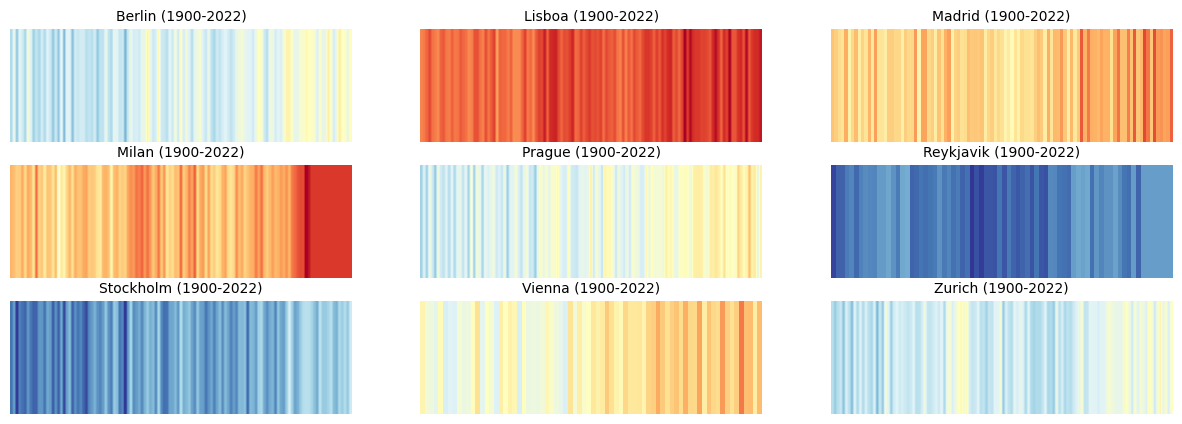

In [11]:
cities = ['berlin', 'lisboa', 'madrid', 'milan', 'prague', 'reykjavik', 'stockholm', 'vienna', 'zurich']

# Create subplots for each city
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 5))

# Loop over cities and plot climate stripes in each subplot
for i, city in enumerate(cities):
    row, col = divmod(i, 3)

    ax = axes[row, col]
    
    # Load Data
    df = pd.read_csv(f'data/eca/{city}.txt', delimiter=',')
    df.columns = df.columns.str.strip()

    # Extract Year and Month from Date
    df['year'] = df['DATE'].astype(str).str.slice(0, 4)
    df['month'] = df['DATE'].astype(str).str.slice(4, 6)
    # Set date as index
    df = df.set_index(pd.to_datetime(df['DATE'], format='%Y%m%d'))
    df = df.rename_axis(None)

    df['celsius'] = df['TG'] /  10
    def replace_missing_celsius(df):
        missing_rows = df.loc[df['celsius'] == -999.9]
        if len(missing_rows) == 0:
            return df
        for index, row in missing_rows.iterrows():
            prev_year_celsius = None
            year = index.year
            while prev_year_celsius is None and year >= df.index.min().year:
                try:
                    prev_year_celsius = df.loc[f'{year-1}-{index.month}-{index.day}']['celsius']
                except KeyError:
                    # Handle leap year
                    if index.month == 2 and index.day == 29:
                        prev_year_celsius = df.loc[f'{year-1}-02-28']['celsius']
                    year -= 1
            if prev_year_celsius is None:
                prev_year_celsius = 0
            df.at[index, 'celsius'] = prev_year_celsius
        return replace_missing_celsius(df)

    df = replace_missing_celsius(df)

    # Slice DataFrame to only include dates up until the end of the previous year
    df_1949_2022 = df.loc['1900-01-01':'2022-12-31']

    # Calculate median temperatures based on modified DataFrame
    df_median_temps = df_1949_2022.groupby('year')['celsius'].median()
    city_avg_celsius = df_median_temps.tolist()

    cmap = plt.cm.get_cmap('RdYlBu_r')
    norm = plt.Normalize(3.4, 18.8)
    #print(f'{city.capitalize()} - Min: {np.min(city_avg_celsius)} Max: {np.max(city_avg_celsius)}')
    image = ax.imshow([city_avg_celsius], cmap=cmap, aspect='auto', norm=norm)
    ax.set_axis_off()
    ax.set_title(f'{city.capitalize()} (1900-2022)', fontsize=10)


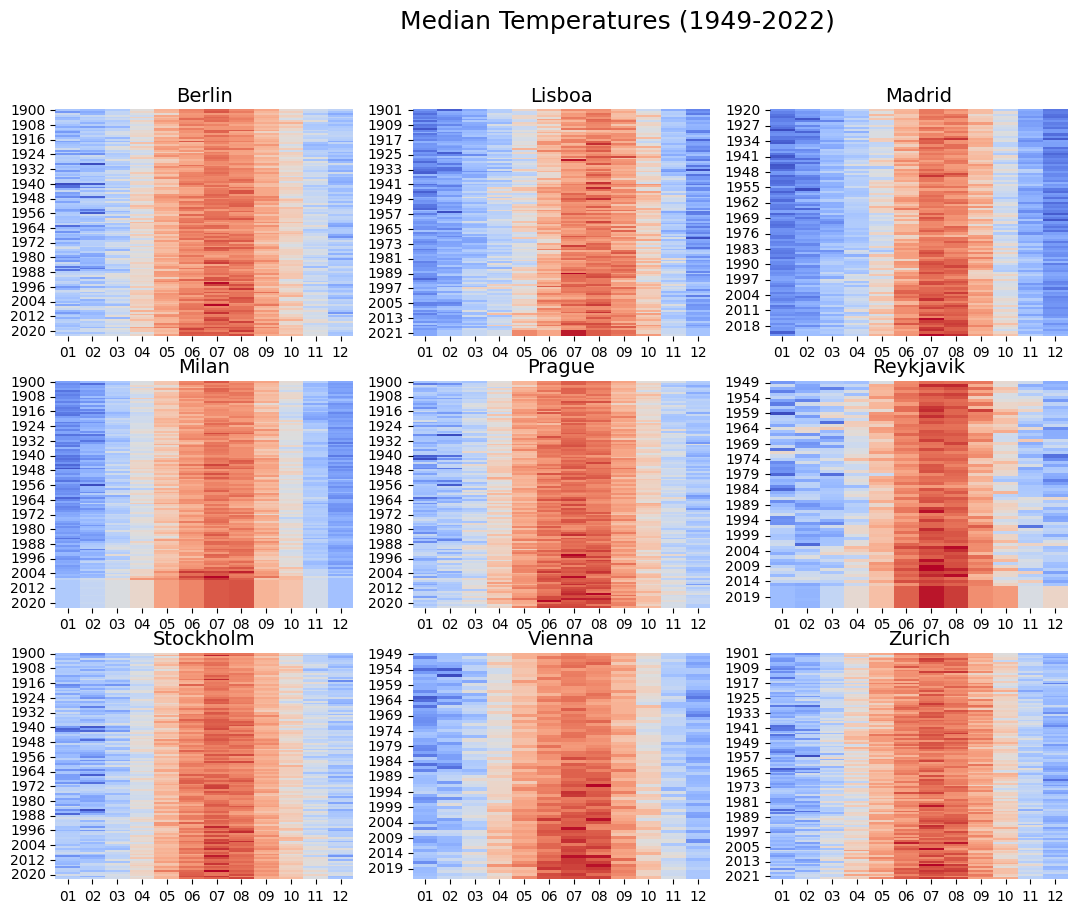

In [12]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
fig.suptitle('Median Temperatures (1949-2022)', fontsize=18)

# Iterate over cities and plot heatmap in corresponding subplot
for i, city in enumerate(cities):
    row = i // 3  # Get row index for subplot
    col = i % 3  # Get column index for subplot

    # Load Data
    df = pd.read_csv(f'data/eca/{city}.txt', delimiter=',')
    df.columns = df.columns.str.strip()

    # Extract Year and Month from Date
    df['year'] = df['DATE'].astype(str).str.slice(0, 4)
    df['month'] = df['DATE'].astype(str).str.slice(4, 6)
    # Set date as index
    df = df.set_index(pd.to_datetime(df['DATE'], format='%Y%m%d'))
    df = df.rename_axis(None)

    df['celsius'] = df['TG'] /  10
    
    # Replace missing celsius values
    def replace_missing_celsius(df):
        missing_rows = df.loc[df['celsius'] == -999.9]
        if len(missing_rows) == 0:
            return df
        for index, row in missing_rows.iterrows():
            prev_year_celsius = None
            year = index.year
            while prev_year_celsius is None and year >= df.index.min().year:
                try:
                    prev_year_celsius = df.loc[f'{year-1}-{index.month}-{index.day}']['celsius']
                except KeyError:
                    # Handle leap year
                    if index.month == 2 and index.day == 29:
                        prev_year_celsius = df.loc[f'{year-1}-02-28']['celsius']
                    year -= 1
            if prev_year_celsius is None:
                prev_year_celsius = 0
            df.at[index, 'celsius'] = prev_year_celsius
        return replace_missing_celsius(df)

    df = replace_missing_celsius(df)

    # Slice DataFrame to only include dates up until the end of the previous year
    df_1949_2022 = df.loc['1900-01-01':'2022-12-31'] 
    df_1949_01_2022_12 = df_1949_2022.groupby(['year', 'month'])['celsius'].median().unstack()

    # Plot heatmap in corresponding subplot
    cmap = plt.get_cmap('coolwarm', 200)
    sns.heatmap(df_1949_01_2022_12, cmap=cmap, ax=axs[row, col], cbar=False)

    # Set title and axis labels
    axs[row, col].set_title(city.capitalize(), fontsize=14)
    axs[row, col].set_xlabel('', fontsize=12)
    axs[row, col].set_ylabel('', fontsize=12)

    # Add colorbar
    fig.subplots_adjust(right=0.8)
    cbar = plt.colorbar(image, ax=ax, orientation='horizontal', pad=0.4, aspect=90)
    cbar.ax.tick_params(labelsize=10)
    cbar.ax.tick_params(axis='x', pad=10)  # add a margin on top
    ax.set_xlabel('', fontsize=10)
    ax.set_ylabel('', fontsize=10)
    ax.set_title(f'{city.capitalize()}, Mitte (1949-2022)', fontsize=12)